This is a duplicate of notebook `1_data_preparation`, that aims to stratify the splits also in the `primary` field.

In [2]:
import json

dataset_path = "/home/peterr/macocu/task5_webgenres/data/original/dataset/dataset.json"

with open(dataset_path, "r") as f:
    dataset = json.load(f)


In [3]:
len(dataset)

1002

# Downsampling rare labels

Rarely occuring primary and secondary labels will be changed as per `Dictionaries_for_genre_mapping.py`:

In [4]:
# First step - categories with less than 5 examples are merged with other categories:
first = {"Script/Drama":"Other", "Lyrical":"Other","FAQ":"Other"}

# Second step - categories (marked by the arrow in the hierarchy figure) are merged with similar categories:
second = {"Recipe":"Instruction", "Research Article":"Information/Explanation", "Review":"Opinion/Argumentation", "Promotion of Services":"Promotion", "Promotion of a Product":"Promotion", "Invitation":"Promotion"}


In [5]:
for i, document in enumerate(dataset):
    primary = document["primary"]
    secondary = document["secondary"]

    if primary in first.keys():
        #print(f"Changing primary from {primary} to {first[primary]}")
        document["primary"] = first[primary]
        
    if secondary in first.keys():
        #print(f"Changing secondary from {secondary} to {first[secondary]}")
        document["secondary"] = first[secondary]

    if primary in second.keys():
        #print(f"Changing primary from {primary} to {second[primary]}")
        document["primary"] = second[primary]

    if secondary in second.keys():
        #print(f"Changing secondary from {secondary} to {second[secondary]}")
        document["secondary"] = second[secondary]

    dataset[i] = document


In total 262 changes were made.

Next: domains will be extracted from urls and saved in the dataset.

In [6]:
urls = [item["url"] for item in dataset]

starts = set([url[0:7] for url in urls])
print("URL starts: ", starts)

ends = set(url[-1] for url in urls)
print("URL ends: ", ends)


URL starts:  {'https:/', 'http://'}
URL ends:  {'L', 'p', 'M', '-', 'a', '=', 'u', '7', 't', '&', '.', 'd', 's', 'c', 'e', 'v', '/', '5', '4', '1', 'h', '8', 'f', 'm', 'y', '3', '9', 'n', 'i', 'g', '6', '0', 'l', 'k', '2', '+', 'o', 'r', 'w', 'j', 'x'}


As we see, all of the URLs start with either http or https. This will make parsing a bit easiers.

In [7]:
import parse

pattern = "{protocol}://{domain}/{rest}"
p = parse.compile(pattern)

for document in dataset:
    parse_result = p.parse(document["url"])
    try:
        document["domain"] = parse_result["domain"]
    except TypeError:
        print(document["url"])


http://multicsreen.uscom.si/
http://www.miroslav-vilhar.si/
http://www.miroslav-vilhar.si/
http://www.miroslav-vilhar.si/
http://pizza-grad.com/
https://postni-nabiralniki.si/
https://www.estet-interier.si/


As we see, this is a situation where we crawled URLs that do not have anything after the third slash. This will be solved by using a modified pattern, as can be seen below:

In [8]:
import parse

pattern = "{protocol}://{domain}/{rest}"
p = parse.compile(pattern)

modified_pattern = "{protocol}://{domain}/"
mp = parse.compile(modified_pattern)
for document in dataset:
    parse_result = p.parse(document["url"])
    try:
        document["domain"] = parse_result["domain"]
    except TypeError:
        parse_result = mp.parse(document["url"])
        document["domain"] = parse_result["domain"]


Let's inspect the first element to be sure that the documents have been modified correctly:

In [9]:
dataset[0]

{'id': '3949',
 'url': 'http://www.pomurje.si/aktualno/sport/zimska-liga-malega-nogometa/',
 'crawled': '2014',
 'primary': 'News/Reporting',
 'secondary': '',
 'tertiary': '',
 'hard': False,
 'paragraphs': [{'text': 'Šport', 'duplicate': False, 'keep': True},
  {'text': 'Zimska liga malega nogometa sobota, 12.02.2011',
   'duplicate': False,
   'keep': True},
  {'text': 'avtor: Tonček Gider', 'duplicate': False, 'keep': True},
  {'text': "V 7. krogu zimske lige v malem nogometu v Križevcih pri Ljutomeru je v prvi ligi vodilni 100 plus iz Križevec izgubil s tretjo ekipo na lestvici Rock'n roll iz Križevec z rezultatom 1:2, druga na lestvici Top Finedika iz Križevec je bila poražena z ekipo Bar Milene iz Ključarovec z rezultatom 7:8. V drugi križevski ligi je vodilni Cafe del Mar iz Vučje vasi premagal Montažo Vrbnjak iz Stare Nove vasi z rezultatom 3:2.",
   'duplicate': False,
   'keep': True},
  {'text': 'oglasno sporočilo', 'duplicate': False, 'keep': True},
  {'text': 'Ocena', 'du

# Transforming the dataset in tabular form

In [10]:
fields = dataset[0].keys()
fields

dict_keys(['id', 'url', 'crawled', 'primary', 'secondary', 'tertiary', 'hard', 'paragraphs', 'domain'])

In [11]:
tabular_dataset = dict()
for field in fields:
    tabular_dataset[field] = [item[field] for item in dataset]
tabular_dataset["stratum"] = [item["primary"] + item["crawled"] for item in dataset]

In [13]:
import pandas as pd

df = pd.DataFrame(data=tabular_dataset)
interim_dir = "/home/peterr/macocu/task5_webgenres/data/interim"
df.to_csv(interim_dir+"/tabular_1b.csv", index=False)
df.head()

,id,url,crawled,primary,secondary,tertiary,hard,paragraphs,domain,stratum
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,News/Reporting,,,False,"[{'text': 'Šport', 'duplicate': False, 'keep':...",www.pomurje.si,News/Reporting2014
1,3726,http://www.ss-sezana.si/sss/index.php?option=c...,2014,Information/Explanation,,,False,"[{'text': 'JEDILNIK', 'duplicate': False, 'kee...",www.ss-sezana.si,Information/Explanation2014
2,5621,http://www.kamnik-starejsi.si/novice/144-sodel...,2014,Promotion,Opinion/Argumentation,Information/Explanation,False,"[{'text': 'Projekt INNOVAge in zavod Oreli', '...",www.kamnik-starejsi.si,Promotion2014
3,3776,http://www.radiocelje.si/novica.php?id=13007&a...,2014,News/Reporting,,,False,"[{'text': 'V novembru, mesecu preprečevanja od...",www.radiocelje.si,News/Reporting2014
4,2102,http://www.mtv.si/novice/selena-gomez-ponudila...,2014,Opinionated News,,,False,[{'text': 'Selena Gomez ponudila v poslušanje ...,www.mtv.si,Opinionated News2014


In [14]:
df.stratum.unique()

array(['News/Reporting2014', 'Information/Explanation2014',
       'Promotion2014', 'Opinionated News2014', 'Legal/Regulation2014',
       'Forum2014', 'Opinion/Argumentation2014', 'Other2014',
       'Announcement2014', 'Instruction2014',
       'List of Summaries/Excerpts2014', 'Correspondence2014',
       'Prose2014', 'Call2014', 'Interview2014', 'Promotion2021',
       'List of Summaries/Excerpts2021', 'Forum2021', 'Announcement2021',
       'Instruction2021', 'Opinion/Argumentation2021',
       'News/Reporting2021', 'Other2021', 'Information/Explanation2021',
       'Legal/Regulation2021', 'Call2021', 'Opinionated News2021',
       'Correspondence2021', 'Interview2021', 'Prose2021'], dtype=object)

In [15]:
nr_of_domains = df.domain.shape[0]
nr_of_unique_domains = len(df.domain.unique())
print("Unique domains: ", nr_of_unique_domains, " out of ", nr_of_domains)

Unique domains:  721  out of  1002


In [16]:
df["domain_unique"] = False
for domain in df.domain.unique():
    subset = df.loc[df.domain == domain,:]
    if len(subset) == 1:
        df.loc[df.domain == domain, "domain_unique"] = True

In [18]:
from sklearn.model_selection import train_test_split

train, devtest = train_test_split(df, test_size=0.2, stratify=df.stratum, random_state=42)

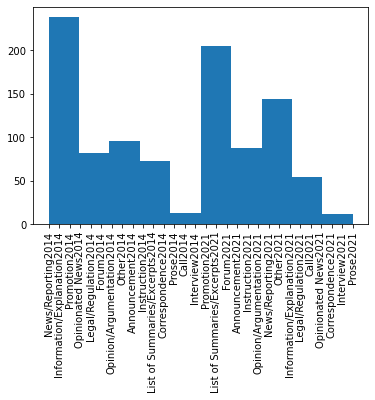

In [20]:
import matplotlib.pyplot as plt
plt.hist(df.stratum)
plt.xticks(rotation=90)
plt.show()

In [21]:
bydomain = df.groupby("domain").count()["id"]
problematic_domains = bydomain[bydomain != 1]
problematic_domains

domain
ars.rtvslo.si               3
astronomija.zlahkoto.si     3
bajta.si                    2
bazar.coks.si               5
bikebook.si                 2
                           ..
www.zurnal24.si            10
www.zvezdni-prah.si         3
www.zvvs.si                 2
zasrce.si                   2
zelisca-cvetka.si           2
Name: id, Length: 165, dtype: int64

In [22]:
problematic_domains.sum()

446

In [23]:
for i, domain in enumerate(problematic_domains.index):
    if domain in train.domain.unique() and domain in devtest.domain.unique():
        print(f"Domain {domain} found in both!", end=" ")
    else:
        continue
    if i%5 == 0:
        indices_to_transfer_to_devtest = train.domain == domain
        devtest = pd.concat([devtest, train[indices_to_transfer_to_devtest]], ignore_index=True)
        train = train[~indices_to_transfer_to_devtest]
    else:
        indices_to_transfer_to_train = devtest.domain == domain
        train = pd.concat([train, devtest[indices_to_transfer_to_train]], ignore_index=True)
        devtest = devtest[~indices_to_transfer_to_train]
    devtest.reset_index(drop=True, inplace=True)
    train.reset_index(drop=True, inplace=True)
    

Domain astronomija.zlahkoto.si found in both! Domain bazar.coks.si found in both! Domain bikebook.si found in both! Domain blog.druzinskapobuda.si found in both! Domain deloindom.delo.si found in both! Domain dk.um.si found in both! Domain dkum.ukm.si found in both! Domain ducan.ednevnik.si found in both! Domain govori.se found in both! Domain irena.blog.siol.net found in both! Domain iza2.zrc-sazu.si found in both! Domain locutio.si found in both! Domain mikec.si found in both! Domain modna.si found in both! Domain predlagam.vladi.si found in both! Domain publishwall.si found in both! Domain radio.ognjisce.si found in both! Domain realmadrid.si found in both! Domain regionalgoriska.si found in both! Domain sodisce.si found in both! Domain user.spletnik.si found in both! Domain vestnik.si found in both! Domain www.24ur.com found in both! Domain www.agencijanet.si found in both! Domain www.agitavit.si found in both! Domain www.atr.si found in both! Domain www.babycenter.si found in both

In [24]:
train.shape[0], devtest.shape[0]

(835, 167)

In [25]:
train.shape[0]/(train.shape[0]+devtest.shape[0])

0.8333333333333334

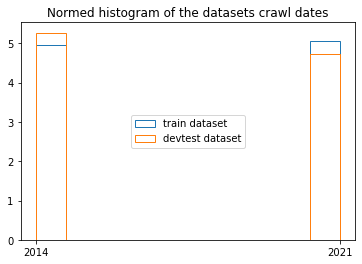

In [26]:
plt.hist(train.crawled, label="train dataset", density=True, histtype="step")
plt.hist(devtest.crawled, label="devtest dataset", density=True, histtype="step")
plt.legend(loc="center")
plt.title("Normed histogram of the datasets crawl dates")
plt.show()

Ok, so this worked suprisingly ok. Let's again test that the data has not leaked into both splits:

In [27]:
for i, domain in enumerate(problematic_domains.index):
    if domain in train.domain.unique() and domain in devtest.domain.unique():
        print(f"Domain {domain} found in both!")

Notice how this produced no hits.

![Good, good](http://www.quickmeme.com/img/5e/5eff1c377f48790ca75a9a9878660481eeb4fde0172a2ad49505dc15890486c8.jpg)

Moving on, we still have to perform the same splitting on dev and test data:

In [28]:
dev, test = train_test_split(devtest, test_size=0.5, stratify=devtest.crawled, random_state=42)

bydomain = devtest.groupby("domain").count()["id"]
problematic_domains = bydomain[bydomain != 1]
problematic_domains

domain
irena.blog.siol.net            2
mikec.si                       3
radio.ognjisce.si              3
www.24ur.com                   4
www.atr.si                     2
www.gov.si                     3
www.joker.si                   2
www.ludliteratura.si           4
www.miroslav-vilhar.si         3
www.pisrs.si                   2
www.preberite.si               2
www.soncek-maribor.si          2
www.spins.si                   3
www.studentska-trgovina.si     2
www.trzican.si                 2
www.viva.si                    3
www.zurnal24.si               10
Name: id, dtype: int64

In [29]:
for i, domain in enumerate(problematic_domains.index):
    if domain in test.domain.unique() and domain in dev.domain.unique():
        print(f"Domain {domain} found in both!", end=" ")
    else:
        continue
    if i%2 != 0:
        indices_to_transfer_to_dev = test.domain == domain
        dev = pd.concat([dev, test[indices_to_transfer_to_dev]], ignore_index=True)
        test = test[~indices_to_transfer_to_dev]
    else:
        indices_to_transfer_to_test = dev.domain == domain
        test = pd.concat([test, dev[indices_to_transfer_to_test]], ignore_index=True)
        dev = dev[~indices_to_transfer_to_test]
    dev.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)

Domain mikec.si found in both! Domain radio.ognjisce.si found in both! Domain www.24ur.com found in both! Domain www.atr.si found in both! Domain www.gov.si found in both! Domain www.ludliteratura.si found in both! Domain www.miroslav-vilhar.si found in both! Domain www.pisrs.si found in both! Domain www.soncek-maribor.si found in both! Domain www.spins.si found in both! Domain www.studentska-trgovina.si found in both! Domain www.trzican.si found in both! Domain www.zurnal24.si found in both! 

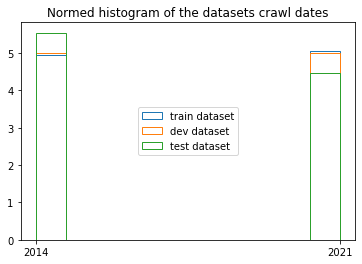

In [35]:
density = True

plt.hist(train.crawled, label="train dataset", density=density, histtype="step")
plt.hist(dev.crawled, label="dev dataset", density=density, histtype="step")
plt.hist(test.crawled, label="test dataset", density=density, histtype="step")
plt.legend(loc="center")
plt.title("Normed histogram of the datasets crawl dates")
plt.savefig("images/1b_crawled.png")
plt.show()

In [31]:
bydomain = df.groupby("domain").count()["id"]
problematic_domains = bydomain[bydomain != 1]

for i, domain in enumerate(problematic_domains.index):
    is_in_train = domain in train.domain.unique()
    is_in_dev = domain in dev.domain.unique()
    is_in_test = domain in test.domain.unique()
    if sum([is_in_train, is_in_dev, is_in_test]) > 1:
        print(f"Domain {domain} found in more than one split!")

As this histogram and the lack of output from the last cell show, we successfully performed the stratified and leak-proof spilling!

![](https://www.bestpuppy.com/assets/images/bestpuppy/Hooray_For_Play_Time.jpg)

We can now save the data and use it later to perform whatever we wish.


In [32]:
import os

interim_dir = "/home/peterr/macocu/task5_webgenres/data/interim"

train.to_csv(os.path.join(interim_dir, "train_1b.csv"), index=False)
test.to_csv(os.path.join(interim_dir, "test_1b.csv"), index=False)
dev.to_csv(os.path.join(interim_dir, "dev_1b.csv"), index=False)

Let's check how the ratios of hardness and primary labels look like across the three splits:

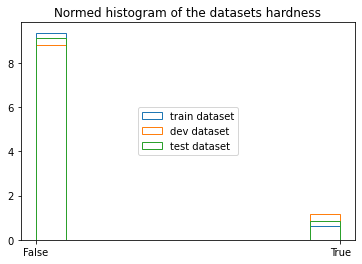

In [36]:
density = True

plt.hist(train.hard.apply(lambda b: str(b)), label="train dataset", density=density, histtype="step")
plt.hist(dev.hard.apply(lambda b: str(b)), label="dev dataset", density=density, histtype="step")
plt.hist(test.hard.apply(lambda b: str(b)), label="test dataset", density=density, histtype="step")
plt.legend(loc="center")
plt.title("Normed histogram of the datasets hardness")
plt.savefig("images/1b_hardness.png")
plt.show()

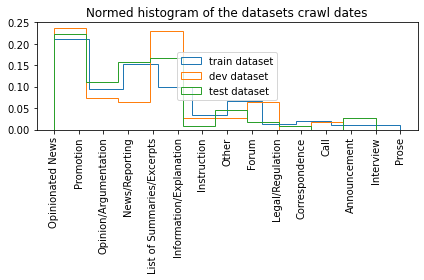

In [43]:
density = True

plt.hist(train.primary, label="train dataset", density=density, histtype="step")
plt.hist(dev.primary, label="dev dataset", density=density, histtype="step")
plt.hist(test.primary, label="test dataset", density=density, histtype="step")
plt.legend(loc="center")
plt.title("Normed histogram of the datasets crawl dates")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("images/1b_primaries.png")
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text major ticklabel objects>)

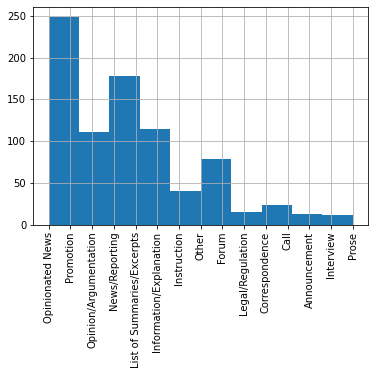

In [42]:
pd.plotting.hist_series(train.primary)
plt.xticks(rotation=90)

(array([2., 0., 1., 0., 1., 0., 1., 0., 1., 1.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

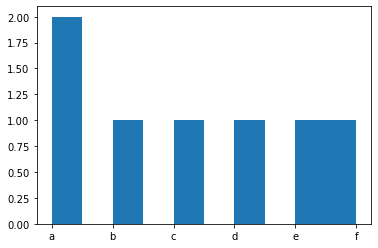

In [48]:
plt.hist(["a","a", "b", "c", "d", "e", "f"], align="mid")